# kNN & Random Forest

In [2]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Load Data

In [3]:
# Load labels DataFrame
labels_df = pd.read_csv('../labels.csv') 
image_dir = '../images'

# Assuming 'Filename' and 'Species' are columns in your labels DataFrame
image_filenames = labels_df['Filename'].values
y = labels_df['Species'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y_encoded):
    raise ValueError("Number of images and labels do not match.")


### Data Splitting

In [4]:
# Split the data into training and test sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    image_paths, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Print label distributions
print("Training label distribution:", Counter(y_train))
print("Testing label distribution:", Counter(y_test))

Training label distribution: Counter({np.int64(2): 7285, np.int64(0): 900, np.int64(7): 859, np.int64(1): 851, np.int64(5): 849, np.int64(3): 825, np.int64(4): 818, np.int64(8): 813, np.int64(6): 807})
Testing label distribution: Counter({np.int64(2): 1821, np.int64(0): 225, np.int64(7): 215, np.int64(1): 213, np.int64(5): 213, np.int64(3): 206, np.int64(4): 204, np.int64(8): 203, np.int64(6): 202})


### Undersampling

In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Identify the majority class in the training set
class_counts = Counter(y_train)
majority_class = max(class_counts, key=class_counts.get)

# Determine the number of samples to keep for the majority class
min_class_count = min(class_counts.values())
sampling_strategy = {majority_class: min_class_count}

# Prepare for undersampling
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

# Since undersampler works on arrays, convert lists to arrays and reshape
X_train_paths_array = np.array(X_train_paths).reshape(-1, 1)

# Apply undersampling
X_resampled_paths, y_resampled = undersampler.fit_resample(X_train_paths_array, y_train)

# Flatten back to 1D array
X_resampled_paths = X_resampled_paths.flatten()

# Print label distribution after undersampling
print("Training label distribution after undersampling:", Counter(y_resampled))

Training label distribution after undersampling: Counter({np.int64(0): 900, np.int64(7): 859, np.int64(1): 851, np.int64(5): 849, np.int64(3): 825, np.int64(4): 818, np.int64(8): 813, np.int64(2): 807, np.int64(6): 807})


### Preprocessing Function

In [6]:
import cv2

def f3(img_path, size=(128, 128), kernel_size=(5, 5), apply_edge_detection=True, edge_type='sobel'):
    img = cv2.imread(img_path, 0)  # Load image as grayscale
    if img is None:
        print(f"Warning: Unable to read image at {img_path}")
        return None
    # Resize image
    img = cv2.resize(img, size)
    # Apply Gaussian Smoothing
    img = cv2.GaussianBlur(img, kernel_size, 0)
    # Apply edge detection
    if apply_edge_detection:
        if edge_type == 'sobel':
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
            img = cv2.magnitude(sobelx, sobely)
        elif edge_type == 'prewitt':
            kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
            kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
            prewittx = cv2.filter2D(img, -1, kernelx)
            prewitty = cv2.filter2D(img, -1, kernely)
            img = cv2.magnitude(prewittx, prewitty)
        elif edge_type == 'canny':
            img = cv2.Canny(img, 100, 200)
    img = img / 255.0  # Normalize pixel values
    img = img.flatten()
    return img

### Preprocess Training Images

In [7]:
# Preprocess training images
X_train_processed = []
for path in X_resampled_paths:
    img = f3(path)
    if img is not None:
        X_train_processed.append(img)
    else:
        # Handle missing images if necessary
        pass

X_train_processed = np.array(X_train_processed)
y_train_processed = y_resampled  # Labels are already aligned

# Ensure the number of images matches the number of labels
if len(X_train_processed) != len(y_train_processed):
    raise ValueError("Mismatch between processed training images and labels.")

print("Processed training data shape:", X_train_processed.shape)

Processed training data shape: (7529, 16384)


### Preprocess Testing Images

In [8]:
# Preprocess testing images
X_test_processed = []
for path in X_test_paths:
    img = f3(path)
    if img is not None:
        X_test_processed.append(img)
    else:
        # Handle missing images if necessary
        pass

X_test_processed = np.array(X_test_processed)
y_test_processed = y_test  # Labels are already aligned

# Ensure the number of images matches the number of labels
if len(X_test_processed) != len(y_test_processed):
    raise ValueError("Mismatch between processed testing images and labels.")

print("Processed testing data shape:", X_test_processed.shape)

Processed testing data shape: (3502, 16384)


### Apply CLAHE to training images

In [9]:
# Reshape images to 2D
image_height, image_width = 128, 128
X_train_images = X_train_processed.reshape(-1, image_height, image_width)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
X_train_clahe = np.array([
    clahe.apply(np.uint8(img * 255)) / 255.0 for img in X_train_images
])

# Flatten images back
X_train_final = X_train_clahe.reshape(X_train_clahe.shape[0], -1)

### Apply CLAHE to testing images

In [10]:
# Reshape images to 2D
X_test_images = X_test_processed.reshape(-1, image_height, image_width)

# Apply CLAHE
X_test_clahe = np.array([
    clahe.apply(np.uint8(img * 255)) / 255.0 for img in X_test_images
])

# Flatten images back
X_test_final = X_test_clahe.reshape(X_test_clahe.shape[0], -1)

### Data Preprocessing (PCA)


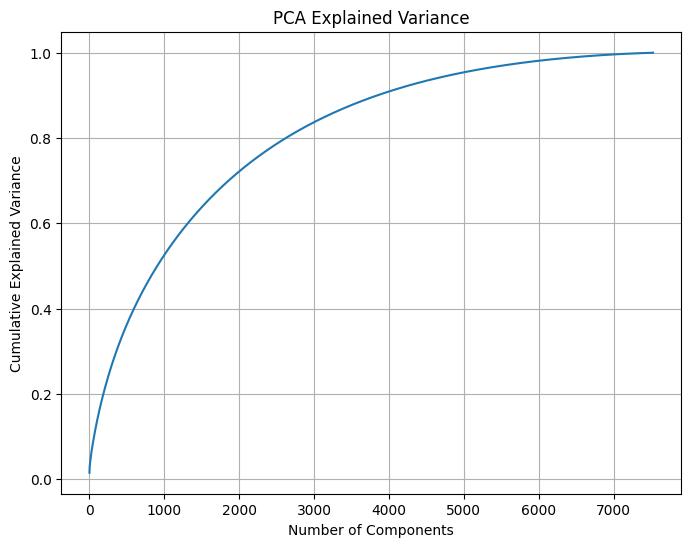

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_full = PCA().fit(X_train_final)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

##### As more principal components are included, the cumulative explained variance increases. The graph helps identify the optimal number of components to use for dimensionality reduction while retaining most of the variance. 

In [11]:
apply_PCA = False

if apply_PCA:
    pca = PCA(n_components=2500, random_state=42)
    X_train_pca = pca.fit_transform(X_train_final)
    X_test_pca = pca.transform(X_test_final)

    print(f'Original number of features: {X_train_final.shape[1]}')
    print(f'Reduced number of features after PCA: {X_train_pca.shape[1]}')
else:
    X_train_pca = X_train_final
    X_test_pca = X_test_final

### Model Training -kNN


##### k-Nearest Neighbors(kNN) is a simple, non-parametric machine learning algorithm commonly used for both classification and regression tasks. It operates based on the principle of similarity, where the outcome for a given data point is influenced by the outcomes of its nearest neighbors in the feature space. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

k_values = [1, 3, 5, 7, 9, 11, 13, 15]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_pca, y_resampled)
    y_pred_knn = knn.predict(X_test_pca)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    print(f'kNN Accuracy with k={k}: {accuracy_knn:.4f}')

kNN Accuracy with k=1: 0.4649
kNN Accuracy with k=3: 0.4960
kNN Accuracy with k=5: 0.4977
kNN Accuracy with k=7: 0.5054
kNN Accuracy with k=9: 0.5086
kNN Accuracy with k=11: 0.5128
kNN Accuracy with k=13: 0.5134
kNN Accuracy with k=15: 0.5126


### Classification Report

In [17]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Make kNN predictions with k=13
knn = KNeighborsClassifier(n_neighbors=13, n_jobs=-1)
knn.fit(X_train_pca, y_resampled)
y_pred_knn = knn.predict(X_test_pca)

# Evaluate using macro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='macro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Macro-averaged Precision: {precision:.2f}")
print(f"Macro-averaged Recall: {recall:.2f}")
print(f"Macro-averaged F1 score: {f1:.2f}")

# Classification Report
print(classification_report(y_test,y_pred_knn,target_names=target_names))

Macro-averaged Precision: 0.09
Macro-averaged Recall: 0.11
Macro-averaged F1 score: 0.08
                precision    recall  f1-score   support

 Chinese Apple       0.00      0.00      0.00       225
       Lantana       0.00      0.00      0.00       213
   Parkinsonia       0.52      0.99      0.68      1821
    Parthenium       0.25      0.02      0.04       206
Prickly acacia       0.00      0.00      0.00       204
   Rubber vine       0.00      0.00      0.00       213
     Siam weed       0.00      0.00      0.00       202
    Snake Weed       0.00      0.00      0.00       215
     Negatives       0.00      0.00      0.00       203

      accuracy                           0.51      3502
     macro avg       0.09      0.11      0.08      3502
  weighted avg       0.29      0.51      0.36      3502



/Users/ichaeyeon/Desktop/weed_classification/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichaeyeon/Desktop/weed_classification/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichaeyeon/Desktop/weed_classification/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Confusion Matrix

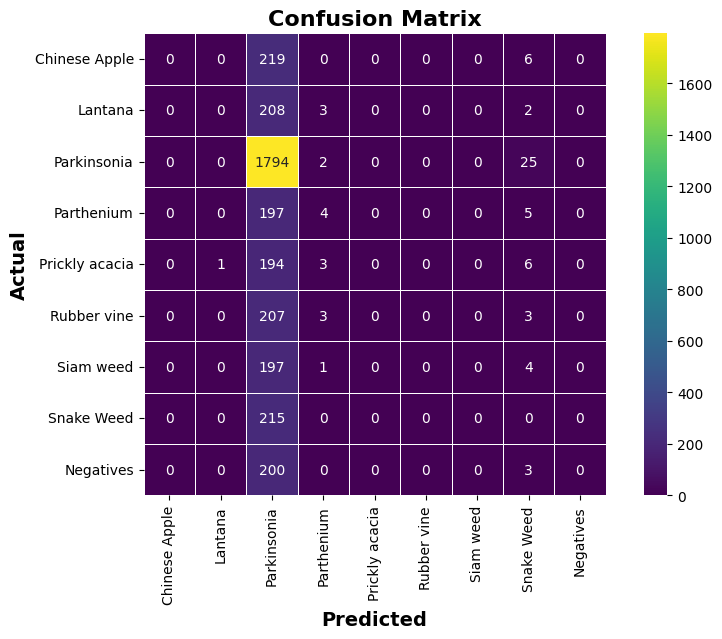


Confusion Matrix:
 [[   0    0  219    0    0    0    0    6    0]
 [   0    0  208    3    0    0    0    2    0]
 [   0    0 1794    2    0    0    0   25    0]
 [   0    0  197    4    0    0    0    5    0]
 [   0    1  194    3    0    0    0    6    0]
 [   0    0  207    3    0    0    0    3    0]
 [   0    0  197    1    0    0    0    4    0]
 [   0    0  215    0    0    0    0    0    0]
 [   0    0  200    0    0    0    0    3    0]]


In [18]:
# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()
print("\nConfusion Matrix:\n", conf_matrix)

### Hyperparameter Tuning for kNN

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions_knn = {
    'n_neighbors': np.arange(1, 21),  # Focused range for k
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier(n_jobs=-1)
random_search_knn = RandomizedSearchCV(knn, param_distributions_knn, 
                                       n_iter=20,  # Reduced number of random combinations
                                       cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_knn.fit(X_train_pca, y_resampled)

print("Best parameters for kNN:", random_search_knn.best_params_)

# Evaluate on test set
best_knn = random_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Test Accuracy for best kNN: {accuracy_knn:.4f}')
print("Classification Report for best kNN:")
print(classification_report(y_test, y_pred_knn))


### Model Training - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_resampled)
y_pred_rf = rf.predict(X_test_pca)

# Evaluation Metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.15
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.08      0.12      0.09       225
           1       0.06      0.08      0.07       213
           2       0.53      0.15      0.23      1821
           3       0.08      0.13      0.10       206
           4       0.10      0.13      0.11       204
           5       0.09      0.11      0.10       213
           6       0.14      0.08      0.10       202
           7       0.09      0.53      0.16       215
           8       0.14      0.09      0.11       203

    accuracy                           0.15      3502
   macro avg       0.14      0.16      0.12      3502
weighted avg       0.32      0.15      0.17      3502

